# Prelim Skills Exam
Name: Zapanta, Jaison Martin<br>
Section: CPE32S8

1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

3.  Use the assigned pre-trained model and fine-tuned it.

4. Build and train a CNN model using the modified pretrained model.

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, GlobalAveragePooling2D
from keras.applications import resnet50

from keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

### Creating the dataset

In [ ]:
# Load the dataset for the data entries
filepath = '/content/drive/MyDrive/CPE313S8/Prelim Exam/sample_labels.csv'
data = pd.read_csv(filepath)

Let's include the image paths to the data entry dataset.

In [ ]:
# Path to the folder containing the images
folder = '/content/drive/MyDrive/CPE313S8/Prelim Exam/sample'

# Find the image paths
def find_image_path(image_index):
    image_path = os.path.join(folder, 'images', image_index)
    if os.path.exists(image_path):
      return image_path.replace('\\', '/')
    return None

# Add a new column to store image paths
data['Image Path'] = data['Image Index'].apply(find_image_path)

In [ ]:
data.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139,/content/drive/MyDrive/CPE313S8/Prelim Exam/sa...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
 11  Image Path                   5606 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 525.7+ KB


In [ ]:
# data_entry_2017['Finding Labels'].unique()

The labels are separated by "|".

In [ ]:
# Perform one-hot encoding
one_hot_encoded = data['Finding Labels'].str.get_dummies(sep='|')
data = pd.concat([data, one_hot_encoded], axis=1)
data.drop(columns='Finding Labels', inplace=True)

In [ ]:
# Drop the label for 'No Finding'
data.drop(columns='No Finding', inplace=True)

In [ ]:
data.head(10)

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,5,13,060Y,M,AP,3056,2544,0.139,0.139,...,0,1,0,0,1,0,0,1,0,1
1,00000013_026.png,26,13,057Y,M,AP,2500,2048,0.168,0.168,...,0,1,0,0,0,0,0,0,0,0
2,00000017_001.png,1,17,077Y,M,AP,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,1,30,079Y,M,PA,2992,2991,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,1,32,055Y,F,AP,2500,2048,0.168,0.168,...,1,0,0,0,0,0,0,0,0,0
5,00000040_003.png,3,40,068Y,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
6,00000042_002.png,2,42,071Y,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,0,0
7,00000057_001.png,1,57,071Y,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,0,0
8,00000061_002.png,2,61,077Y,M,PA,2992,2991,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
9,00000061_019.png,19,61,077Y,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,0,0


### Splitting the data to Training and Testing sets

In [ ]:
def x_y_split(dataset, target_columns):
    # Get the target column
    y = []
    y = dataset[target_columns].values

    # Get the feature column (images)
    X = []
    for image_path in dataset['Image Path']:
        img = cv2.imread(image_path)
        X.append(cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC))

    return X, y

In [ ]:
# Define the target columns
target_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                  'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                  'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

X, y = x_y_split(data, target_columns)

In [ ]:
# Convert X to a multi-dimensional array
X = np.array(X)
# Normalize pixel values between to 0 and 1
X = X.astype('float32') / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=69)

### Building a model from scratch
The model structure is a result of trial-and-error.

In [ ]:
# Define the CNN model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                        

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
141/141 [==============================] - 870s 6s/step - loss: 0.2080 - binary_accuracy: 0.9461 - val_loss: 0.1880 - val_binary_accuracy: 0.9473
Epoch 2/5
141/141 [==============================] - 868s 6s/step - loss: 0.1848 - binary_accuracy: 0.9505 - val_loss: 0.1905 - val_binary_accuracy: 0.9473
Epoch 3/5
141/141 [==============================] - 843s 6s/step - loss: 0.1816 - binary_accuracy: 0.9506 - val_loss: 0.1892 - val_binary_accuracy: 0.9473
Epoch 4/5
141/141 [==============================] - 838s 6s/step - loss: 0.1784 - binary_accuracy: 0.9506 - val_loss: 0.1847 - val_binary_accuracy: 0.9473
Epoch 5/5
141/141 [==============================] - 838s 6s/step - loss: 0.1752 - binary_accuracy: 0.9505 - val_loss: 0.1845 - val_binary_accuracy: 0.9473


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

loss_print = format(loss, '.2f')
accuracy_print = format(accuracy*100, '.2f') + '%'

36/36 [==============================] - 46s 1s/step - loss: 0.1845 - binary_accuracy: 0.9473


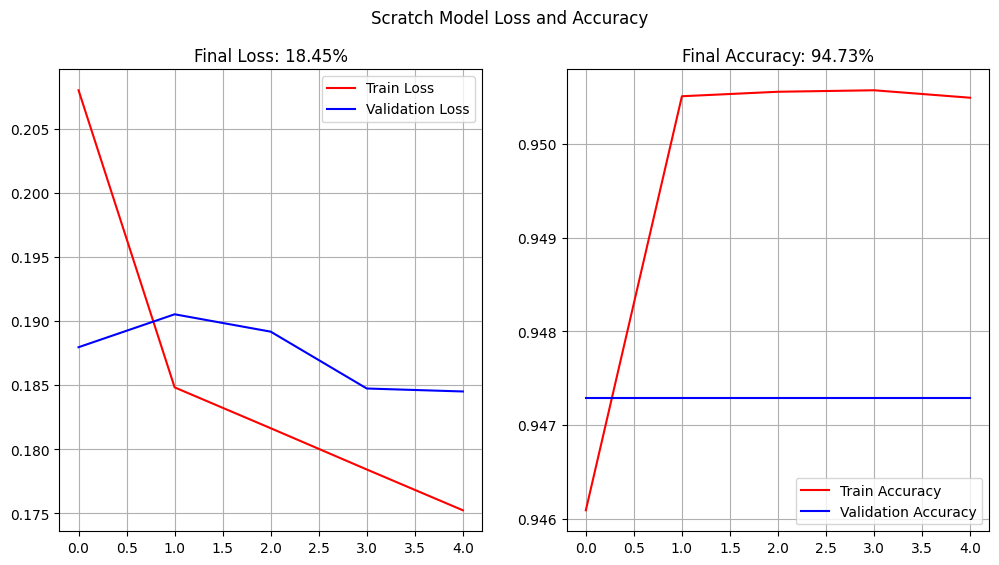

In [ ]:
# Plot the training and validation loss and accuracy
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r', label="Train Loss")
ax.plot(history.history["val_loss"],'b', label="Validation Loss")
ax.legend()
ax.set_title(f'Final Loss: {loss_print}')
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["binary_accuracy"],'r', label="Train Accuracy")
ax.plot(history.history["val_binary_accuracy"],'b', label="Validation Accuracy")
ax.legend()
ax.set_title(f'Final Accuracy: {accuracy_print}')
ax.grid(True)

fig.suptitle('Scratch Model Loss and Accuracy')
plt.show()

> The validation accuracy for the scratch model was consistently 94.73% for the entire training time, which is above the required 85%

### Using a pre-trained model
I initially decided to use ResNet50 because it was the highest performing model solely based on a previous Hands-on Activity.

In [ ]:
# Load pre-trained ResNet50 model
resnet50_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add custom classification head
features = resnet50_model.output
features = GlobalAveragePooling2D()(features)
features = Dense(512, activation='relu')(features)
predictions = Dense(14, activation='sigmoid')(features)

# Combine base model with custom classification head
model_1 = Model(inputs=resnet50_model.input, outputs=predictions)

In [ ]:
# Freeze the layers of the base model
for layer in resnet50_model.layers:
    layer.trainable = False

In [ ]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Compile the model
model_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Train the model
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
141/141 [==============================] - 338s 2s/step - loss: 0.1955 - binary_accuracy: 0.9446 - val_loss: 0.1867 - val_binary_accuracy: 0.9473
Epoch 2/10
141/141 [==============================] - 326s 2s/step - loss: 0.1795 - binary_accuracy: 0.9505 - val_loss: 0.1875 - val_binary_accuracy: 0.9473
Epoch 3/10
141/141 [==============================] - 302s 2s/step - loss: 0.1795 - binary_accuracy: 0.9505 - val_loss: 0.1876 - val_binary_accuracy: 0.9473
Epoch 4/10
141/141 [==============================] - 324s 2s/step - loss: 0.1791 - binary_accuracy: 0.9505 - val_loss: 0.1875 - val_binary_accuracy: 0.9473
Epoch 5/10
141/141 [==============================] - 307s 2s/step - loss: 0.1791 - binary_accuracy: 0.9505 - val_loss: 0.1865 - val_binary_accuracy: 0.9473
Epoch 6/10
141/141 [==============================] - 327s 2s/step - loss: 0.1784 - binary_accuracy: 0.9505 - val_loss: 0.1893 - val_binary_accuracy: 0.9473
Epoch 7/10
141/141 [==============================] - 305s

In [ ]:
# Evaluate the model
loss_1, accuracy_1 = model_1.evaluate(X_test, y_test)

loss_print_1 = format(loss_1, '.2f')
accuracy_print_1 = format(accuracy_1*100, '.2f') + '%'

36/36 [==============================] - 60s 2s/step - loss: 0.1862 - binary_accuracy: 0.9473


Seeing that it fulfilled the job, let's stick with it.

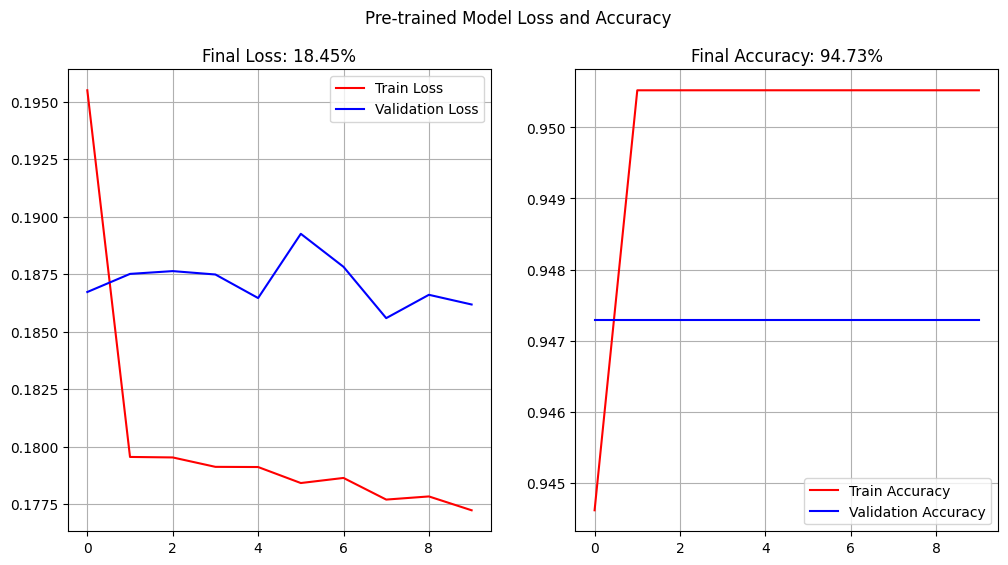

In [ ]:
# Plot the training and validation loss and accuracy
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_1.history["loss"],'r', label="Train Loss")
ax.plot(history_1.history["val_loss"],'b', label="Validation Loss")
ax.legend()
ax.set_title(f'Final Loss: {loss_print}')
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_1.history["binary_accuracy"],'r', label="Train Accuracy")
ax.plot(history_1.history["val_binary_accuracy"],'b', label="Validation Accuracy")
ax.legend()
ax.set_title(f'Final Accuracy: {accuracy_print}')
ax.grid(True)

fig.suptitle('Pre-trained Model Loss and Accuracy')
plt.show()

> The final accuracy for the pre-trained model is also consistently 94.73% for the entire training time duration, which leads me to suspect that there's likely some problem that results in this specific accuracy.

### Evaluating and comparing the two models

In [ ]:
# Make predictions for both models
y_pred = model.predict(X_test)
y_pred_1 = model_1.predict(X_test)

36/36 [==============================] - 63s 2s/step


#### Classification Report

In [ ]:
print("Classification Report for Scartch Model:")
print(classification_report(y_test, y_pred > 0.0))

Classification Report for Scartch Model:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       110
           1       0.03      1.00      0.06        36
           2       0.05      1.00      0.10        57
           3       0.02      1.00      0.03        19
           4       0.12      1.00      0.21       135
           5       0.03      1.00      0.06        34
           6       0.01      1.00      0.02        14
           7       0.00      1.00      0.00         2
           8       0.18      1.00      0.30       200
           9       0.05      1.00      0.10        58
          10       0.06      1.00      0.11        63
          11       0.04      1.00      0.07        40
          12       0.01      1.00      0.01         6
          13       0.05      1.00      0.09        54

   micro avg       0.05      1.00      0.10       828
   macro avg       0.05      1.00      0.10       828
weighted avg       0.10      1.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Classification Report for Pre-trained Model:")
print(classification_report(y_test, y_pred_1 > 0.0))

Classification Report for Pre-trained Model:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       110
           1       0.03      1.00      0.06        36
           2       0.05      1.00      0.10        57
           3       0.02      1.00      0.03        19
           4       0.12      1.00      0.21       135
           5       0.03      1.00      0.06        34
           6       0.01      1.00      0.02        14
           7       0.00      1.00      0.00         2
           8       0.18      1.00      0.30       200
           9       0.05      1.00      0.10        58
          10       0.06      1.00      0.11        63
          11       0.04      1.00      0.07        40
          12       0.01      1.00      0.01         6
          13       0.05      1.00      0.09        54

   micro avg       0.05      1.00      0.10       828
   macro avg       0.05      1.00      0.10       828
weighted avg       0.10      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> As I suspected, while the model is getting most predictions right overall, based on the accuracy of 94.73%, it is also making a large number of false positive predictions. The model is often guessing that certain conditions are present when they're actually not, shown by the low precision scores in the classification report.

#### Confusion Matrix

In [ ]:
# Calculate confusion matrices
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm_1 = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))

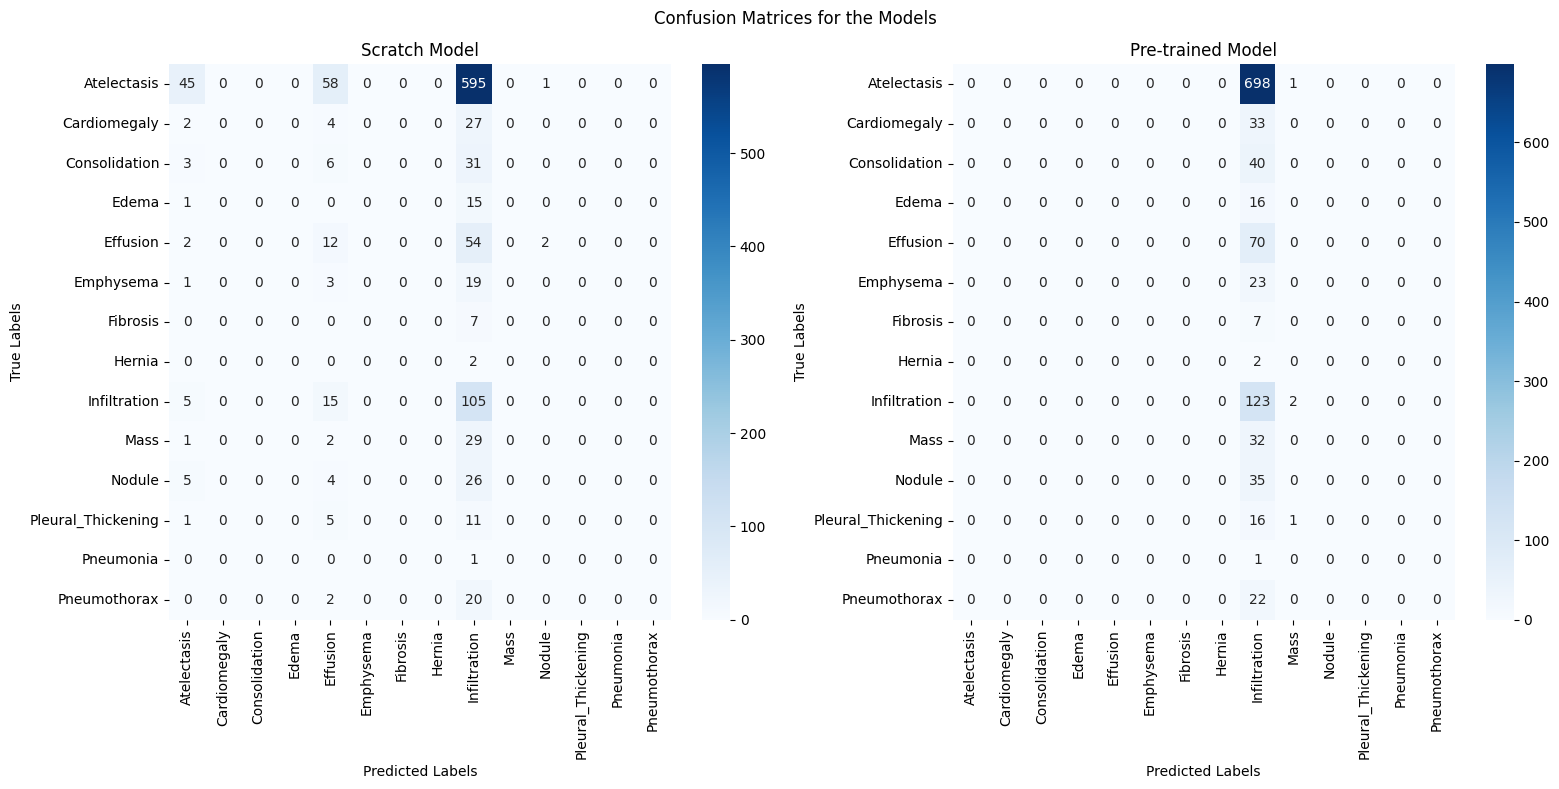

In [ ]:
# Plot confusion matrices
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_columns, yticklabels=target_columns, ax=axes[0])
axes[0].set_title('Scratch Model')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=target_columns, yticklabels=target_columns, ax=axes[1])
axes[1].set_title('Pre-trained Model')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

fig.suptitle('Confusion Matrices for the Models')
plt.tight_layout()
plt.show()

> The mostly zero confusion matrix suggests that the model struggles to differentiate between the different classes, which lead to all the wrong guesses. This aligns with the low precision observed in the classification report.

#### ROC Curve

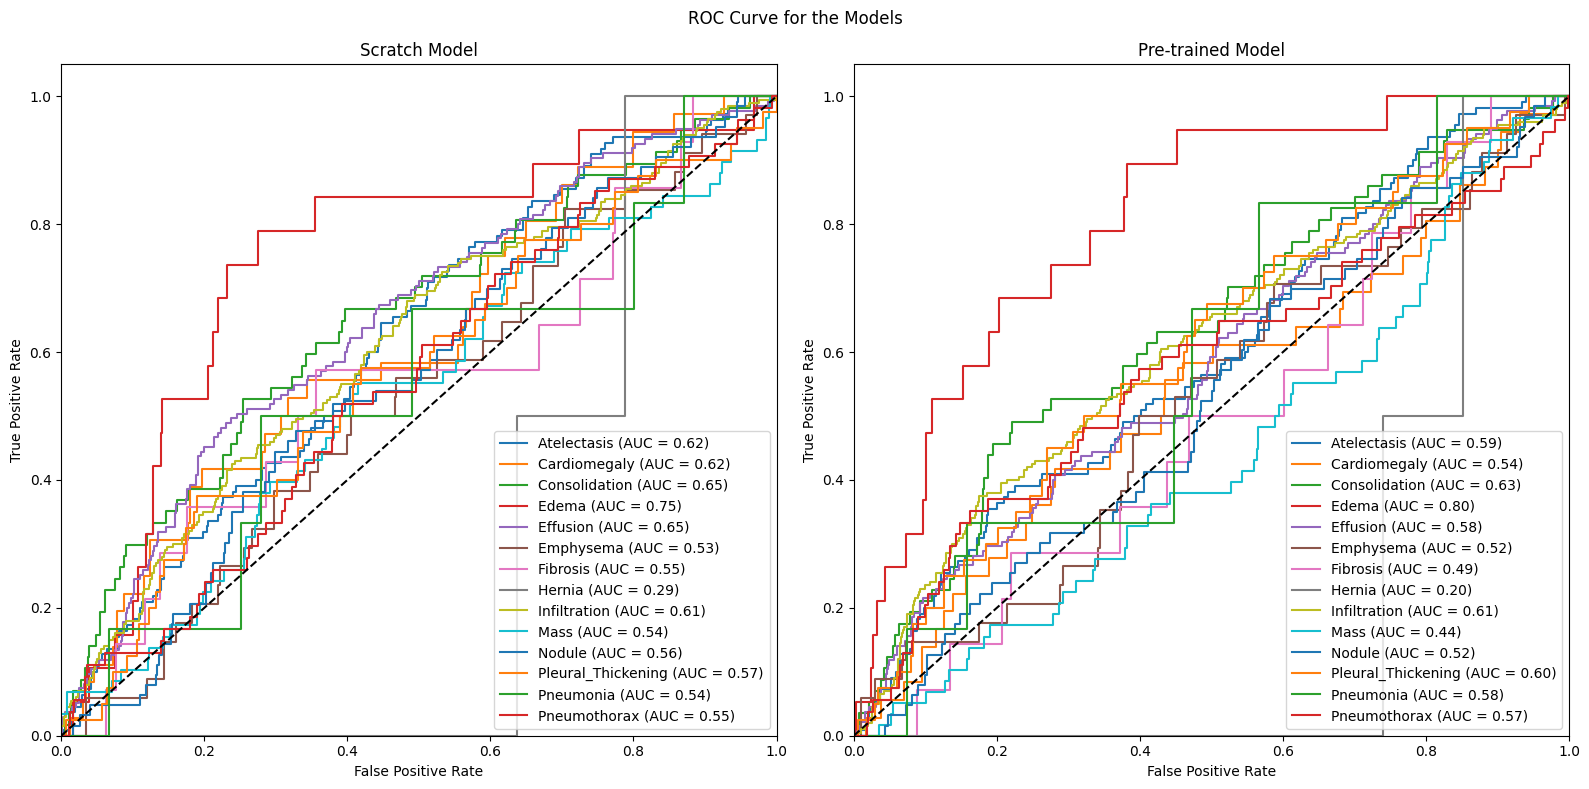

In [ ]:
# Plot ROC curve for each class
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].set_title('Scratch Model')
# Get the curve for each label
for i in range(len(target_columns)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{target_columns[i]} (AUC = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

axes[1].set_title('Pre-trained Model')
# Get the curve for each label
for i in range(len(target_columns)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_1[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'{target_columns[i]} (AUC = {roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc="lower right")

fig.suptitle('ROC Curve for the Models')
plt.tight_layout()
plt.show()

> The ROC curve showing classes being close to the center line or even below the false positive rate implies that it is not effective in differentiating between positive and negative instances. This confirms the model's high false positive rate, leading to misclassifications.

## Conclusion

> The models, in the end, had a **high false positive rate**, indicating a tendency to incorrectly predict the presence of certain conditions. This discrepancy suggests that while the **binary accuracy** appeared high, it may not have provided an accurate reflection of the models' performance, emphasizing the importance of choosing appropriate evaluation metrics. Furthermore, the **limited dataset usage**, accounting for only 5% of the total data, likely played a role in the models' subpar performance. Although re-training the models within the time constraints was not feasible, this experience serves as a valuable lesson for future endeavors, highlighting the significance of comprehensive planning and data exploration in achieving robust model outcomes.